# Playing with the PAL algorithm.

There's something interesting: https://github.com/VitoChan1/PAL-on-Adder-DSE/blob/master/PAL.py

Summarizing the paper (PAL: An Active Learning Approach to the Multi-Objective Optimization Problem form the Puschel group at ETH).

* error bounds based on hypervolume error
* response surface methods for unevaluated designs. Best so far: PareEGO also uses GP
* scalariztion: without assumptions like convexity not all solutions can be recovered

* uncertainity captured with hyperparameter, there is some scaling parameter beta that determines which fraction of the variance is used. 
* then classified as pareto optimal if the pessimistic bound is not dominated by the optimistic outcome of any other point
* if the optimisitc bound is dominated by the pessimistic bound of any other point, then not pareto optimal

In [1]:
import numpy as np 
from tqdm import tqdm

In [2]:
def _get_pareto_optimal(scores: np.array) -> np.array:
    size = scores.shape[0]
    ids = np.arange(size)
    pareto_front = np.ones(size, dtype=bool)
    for j in range(size):
        # Check if our 'i' point is dominated by our 'j' point
        if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
            # j dominates i. Label 'i' point as dominant
            pareto_front[i] = 0
            break
    # Return ids of pareto front
    return ids[pareto_front]

Let's use PyGMO as they have spent more thought into how to implement this: 

https://esa.github.io/pygmo/documentation/hypervolume.html

Implements, e.g., WFG (https://ieeexplore.ieee.org/document/5766730)

In [3]:
import pygmo as pg 
from typing import Union, Iterable
import logging

In [4]:
def get_hypervolume(pareto_front: np.array, reference_vector: np.array) -> float: 
    hyp = pg.hypervolume(pareto_front) 
    volume = hyp.compute(reference_vector) # uses 'auto' algorithm
    return volume

In [5]:
def _get_gp_predictions(gps: Iterable, x_train: np.array, y_train: np.array, x_input: np.array) -> Union[np.array, np.array]: 
    # get the GP predictions, for generality, we will assume a list of GPs
    # one GP per target
    mus = []
    stds = []
    
    # train one GP per target
    for i, gp in enumerate(gps): 
        gp.fit(x_train, y_train[:,i])
        mu, std = gp.predict(x_input, return_std=True)
        mus.append(mu.reshape(-1,1))
        stds.append(std.reshape(-1,1))
    
        
    return np.hstack(mus), np.hstack(stds) 

In [6]:
def _get_uncertainity_region(mu: float, std: float, beta_sqrt: float): 
    low_lim, high_lim = mu -  beta_sqrt * std, mu +   beta_sqrt * std
    return low_lim, high_lim 

In [7]:
def _get_uncertainity_regions(mus: np.array, stds: np.array, beta_sqrt: float): 
    low_lims, high_lims = [], []
    for i in range(0, mus.shape[1]):
        low_lim, high_lim = _get_uncertainity_region(mus[:,i], stds[:,i], beta_sqrt)
        low_lims.append(low_lim.reshape(-1,1))
        high_lims.append(high_lim.reshape(-1,1))
        
    return np.hstack(low_lims), np.hstack(high_lims)

In [8]:
def _union_single_feat(lows: Iterable, ups: Iterable, new_lows: Iterable, new_ups: Iterable) -> Union[Iterable, Iterable]:
    out_lows = []
    out_ups = []
    for i in range(0,len(lows)):
        if (new_lows[i] > ups[i]) or (new_ups[i] < lows[i]) or (lows[i] + ups[i] == 0):
            out_lows.append(0)
            out_ups.append(0)
        else:
            out_lows.append(max(lows[i], new_lows[i]))
            out_ups.append(min(ups[i],new_ups[i]))
            
    return np.array(out_lows), np.array(out_ups)

In [9]:
def _union(lows: Iterable, ups: Iterable, new_lows: Iterable, new_ups: Iterable) -> Union[Iterable, Iterable]:
    # iterative intersection, eq. 6 in paper, make uncertainity regions smaller
    out_lows = []
    out_ups = []
    for i in range(0, lows.shape[1]):
        l, u = _union_single_feat(lows[:,i], ups[:,i], new_lows[:,i], new_ups[:,i])
        out_lows.append(l.reshape(-1,1))
        out_ups.append(u.reshape(-1,1))
    return np.hstack(out_lows), np.hstack(out_ups)

In [10]:
def _update_sampled(mus, stds, sampled, y_input):
    # this is kinda inefficient, better use some kind of indexing 
    for i in range(0,len(mus)):
        if (sampled[i] == 1):
            mus[i, :] = y_input[i, :]
            
            # ToDo: is this true? 
            stds[i, :] = 0
            
    return mus, stds

In [55]:
def _pareto_classify(pareto_optimal_0: list, not_pareto_optimal_0: list, unclassified_0: list, rectangle_lows: np.array, rectangle_ups: np.array, x_input: np.array, epsilon: float) -> Union[list, list, list]:
    pareto_optimal_t = pareto_optimal_0
    not_pareto_optimal_t = not_pareto_optimal_0
    unclassified_t = unclassified_0
    
    # loop over samples 
    for i in range(0, len(x_input)):
        if (unclassified_t[i] == 1):
            pareto = True
            nonpareto = False
            
            # At iteration t, the points in Pt−1 and Nt−1 keep their classification. The only points x to be reclassified are those in Ut−1 , done as follows
            
            # If the pessimistic outcome min(Rt(x)) of x is not dominated by the optimistic outcome max(Rt(x )) of any other point (up to a shift of ε by both),
            if all(rectangle_lows[i] * (1 + epsilon) <= rectangle_ups[i] * (1 - epsilon)):
                pareto = False
                
            # If the optimistic outcome max(Rt(x)) of x is dominated by the pessimistic outcome min(Rt(x′)) of any x′ (up to a shift of ε by both),    
            if any(rectangle_ups[i] * (1 - epsilon) <= rectangle_lows[i] * (1 + epsilon)): 
                nonpareto = True
            
            # All other points remain unclassified.
            if pareto:
                pareto_optimal_t[i] = 1
                unclassified_t[i] = 0
            elif nonpareto:
                not_pareto_optimal_t[i] = 1
                unclassified_t[i] = 0
                
    return pareto_optimal_t, not_pareto_optimal_t, unclassified_t

In [56]:
def _sample(rectangle_lows, rectangle_ups, pareto_optimal_t, non_pareto_optimal_t, unclassified_t, sampled, x_input, y_input, x_train, y_train):
    maxwt = 0
    maxid = -1
    
    for i in range(0,len(x_input)):
        # Among the points x ∈ Pt ∪ Ut, the one with the largest wt(x) is chosen as the next sample xt to be evaluated.
        # Intuitively, this rule biases the sampling towards exploring, and thus improving the model for, the points most likely to be Pareto-optimal.
        if ((unclassified_t[i] == 1) or (pareto_optimal_t[i] == 1)) and not(sampled[i] == 1):
            # weight is the length of the diagonal of the uncertainity region
            wt = np.linalg.norm(rectangle_ups[i,:] - rectangle_lows[i,:])
            if maxid == -1:
                maxwt = wt
                maxid = i
            # the point with the largest weight is chosen as the next sample
            elif wt > maxwt:
                maxwt = wt
                maxid = i
                
    x_train = np.insert(x_train, x_train.shape[0], x_input[maxid], axis = 0)
    y_train = np.insert(y_train, y_train.shape[0], y_input[maxid], axis = 0)
    
    sampled[maxid] = 1
    
    
    return x_train, y_train, sampled


In [89]:
# Here, I assume that we exhaustively sampled, so we can provide y directly as input. Otherwise, there will be a sampling function that can return y
def pal(gps: list, x_train: np.array, y_train: np.array, x_input: np.array, y_input: np.array, hv_reference: Iterable = [10, 10], delta: float = 0.05, epsilon: float = 0.05, iterations: int = 100):
    # x_input is the E set in the PAL paper 
    # the models for now assume the sklearn API, i.e., there should be a fit function 
    assert y_train.shape[1] == len(hv_reference)
    
    hypervolumes = []
   
    # initalize binary list to keep track of the different sets
    # in the beginning, nothing is selected = everything is unclassified
    pareto_optimal_0 = [0] * len(x_input)
    not_pareto_optimal_0 = [0] * len(x_input)
    unclassified_0 = [1] * len(x_input) 
    sampled = [0] * len(x_input)
    
    iteration = 0
    
    logger = logging.getLogger()
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    
    
    logger.info("Starting now the PAL loop")
    logger.debug("Will use the following settings")
    logger.debug("epsilon: {}, delta: {}, iterations: {}".format(epsilon, delta, iterations))
    logger.debug("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))

    # stop when all points are classified 
    while (np.sum(unclassified_0) > 0) and (iteration <= iterations):
        iteration += 1
        logger.debug("Starting iteration {}".format(iteration))
        
        # STEP 1: modeling (train and predict using GPR, one GP per target)
        logger.debug("Starting modeling step, fitting the GPs")
        mus, stds = _get_gp_predictions(gps, x_train, y_train, x_input)
    
        # update scaling parameter β
        # which is achieved by choosing βt = 2 log(n|E|π2t2/(6δ)).
        # n: number of objectives (y_input.shape[1])
        beta = 2 * np.log(y_input.shape[1] * len(x_input) * np.square(np.pi) * np.square(iteration) / (6 * delta))
        logger.debug("Scaling parameter beta at the current iteration is {}".format(beta))
        
        logger.debug("mean array shape: {}, std array shape: {}".format(mus.shape, stds.shape))
        
        # if point is sampled we know the mu and have no epistemic uncertainity    
        mus, stds = _update_sampled(mus, stds, sampled, y_input)
        
        logger.debug("mean array shape: {}, std array shape: {}".format(mus.shape, stds.shape))
        
        # get the uncertainity rectangles, sqrt only once here for efficiency
        lows, ups = _get_uncertainity_regions(mus, stds, np.sqrt(beta))
        
        logger.debug("lows shape {}, ups shape {}".format(lows.shape, ups.shape))
        
        
        if iteration == 1: 
            # initialization
            rectangle_lows, rectangle_ups = lows, ups
        else:
            rectangle_lows, rectangle_ups = _union(rectangle_lows, rectangle_ups, lows, ups)
            
        
        logger.debug("rectangle lows shape {}, rectangle ups shape {}".format(rectangle_lows.shape, rectangle_ups.shape))
        # pareto classification
        # update lists 
        pareto_optimal_t, not_pareto_optimal_t, unclassified_t = _pareto_classify(pareto_optimal_0, 
                                                                                  not_pareto_optimal_0, 
                                                                                  unclassified_0, 
                                                                                  rectangle_lows, 
                                                                                  rectangle_ups, x_input, epsilon)

        
        # sampling from x_input 
        # ToDo: sample multiple structures
        x_train, y_train, sampled = _sample(rectangle_lows, rectangle_ups, pareto_optimal_t, not_pareto_optimal_t, unclassified_t, sampled, x_input, y_input, x_train, y_train)
        pareto_optimal_0, not_pareto_optimal_0, unclassified_0 = pareto_optimal_t, not_pareto_optimal_t, unclassified_t
          
        
        optimal_indices= np.where(np.array(pareto_optimal_0) == 1)[0]

        if len(optimal_indices) > 0:
            hypervolume = get_hypervolume(y_input[optimal_indices], hv_reference) 
        else: 
            hypervolume = np.nan
        
        logger.info('Iteration {} | Pareto optimal {}, not Pareto optimal {}, unclassified {}, hypervolume: {}'.format(iteration, np.array(pareto_optimal_0).sum(), 
                                                                                                                      np.array(not_pareto_optimal_0).sum(), 
                                                                                                                      np.array(unclassified_0).sum(), hypervolume))
       

        
        hypervolumes.append(hypervolume)
        
    return pareto_optimal_t, hypervolumes

In [90]:
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import joblib
import sys
sys.path.append('..')
from dispersant_screener.definitions import *

In [103]:
DATADIR = '../data'
TRAIN_SIZE = 0.01

In [104]:
df_full_factorial = pd.read_csv(os.path.join(DATADIR, 'full_fact.csv'))

In [105]:
X = df_full_factorial[FEATURES]
y = df_full_factorial[TARGETS]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)

In [106]:
get_hypervolume(y_test, [10, 10])

321.53322331919935

We should get close to this ...

In [107]:
virial_model = GaussianProcessRegressor(kernel=Matern(), normalize_y=True, n_restarts_optimizer=1)

In [108]:
gibbs_model = GaussianProcessRegressor(kernel=Matern(), normalize_y=True, n_restarts_optimizer=1)

In [109]:
gps = [virial_model, gibbs_model]

In [110]:
len(X_train)

31

In [111]:
pareto, history = pal(gps, X_train.values, y_train.values, X_test.values,y_test.values)

2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,818 root         INFO     Starting now the PAL loop
2020-06-02 22:03:34,924 root         INFO     Iteration 1 | Pareto optimal 0, not Pareto optimal 0, unclassified 3094, hypervolume: nan
2020-06-02 22:03:34,924 root         INFO     Iteration 1 | Pareto optimal 0, not Pareto optimal 0, unclassified 3094, hypervolume: nan
2020-06-02 22:03:34,924 root         INFO     Iteration 1 | Pareto optimal 0, no

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'hypervolume')

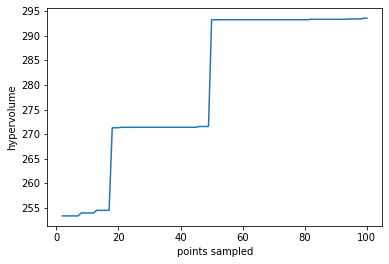

In [113]:
plt.plot(history)
plt.xlabel('points sampled')
plt.ylabel('hypervolume')